# Computer Vision III: Detection, Segmentation and Tracking (CV3DST) (IN2375) Exercise

In this exercise we provide you with a baseline multi-object tracker on the [MOT16](https://motchallenge.net/data/MOT16/) dataset. Your task is to improve its tracking performance by applying different techniques from the lecture. As most modern multi-object trackers, the provided baseline follows the tracking-by-detection paradigm. To this end, an object detector is applied to each frame indepdently and in a subsequent data association step the detections are combined to tracks over multiple frames. The challenge is to connect the correct detections of the same object and produce identity preserving tracks.

The improvement on the provided baseline tracker can be achieved in multiple ways:

*   Improving the object detector.
*   Improving the tracker (data association step).
*   Incorporating segmentation information.

#### Install and import Python libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

root_dir = '..'

import os
import sys
sys.path.append(os.path.join(root_dir, 'src'))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm.autonotebook import tqdm

import torch
from torch.utils.data import DataLoader

from tracker.data_track import MOT16Sequences
from tracker.data_obj_detect import MOT16ObjDetect
from tracker.object_detector import FRCNN_FPN
from tracker.tracker import Tracker
from tracker.utils import (plot_sequence, evaluate_mot_accums, get_mot_accum,
                           evaluate_obj_detect, obj_detect_transforms)

import motmetrics as mm
mm.lap.default_solver = 'lap'

/home/deep/miniconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


# MOT16 dataset

The MOT16 challenge provides 7 train and 7 test video sequences with multiple objects (pedestrians) per frame. It includes many challening scenarios with camera movement, high crowdedness and object occlusions. See the [webpage](https://motchallenge.net/data/MOT16/) for video sequences with ground truth annotation.

The `MOT17Sequences` dataset class provides the possibilty to load single sequences, e.g., `seq_name = 'mot16_02'`, or the entire train/test set, e.g., `seq_name = 'mot16_train'`.

At this point the test set directort is still empty. Later in the semester we will provide you with the necesssary test sequences to submit to our challenge.

In order to compare the tracking performance of different trackers without the effect of the object detector, the MOTChallenge provides a precomputed set of public object detections. Trackers are then evaluated on their capabilities to form tracks with the provided set. However, we want to allow you to improve on the object detections as well. Therefore, we participate in the MOT16 challenge with private detections.

## Instance segmentations

We provide the instance segmentations for the sequences `02`, `05`, `09` and `11`. These can be used for example to train a method which improves the bounding box position in occluded situations. See the original MOTS [webpage](https://www.vision.rwth-aachen.de/page/mots) for more info.

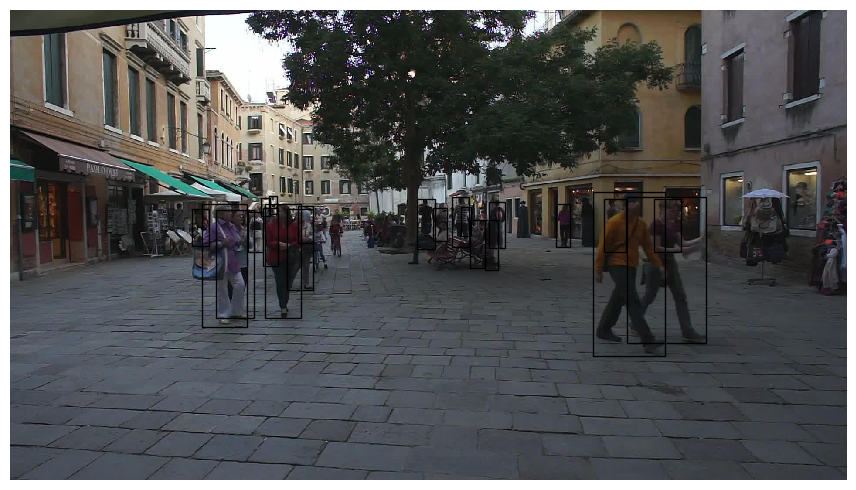

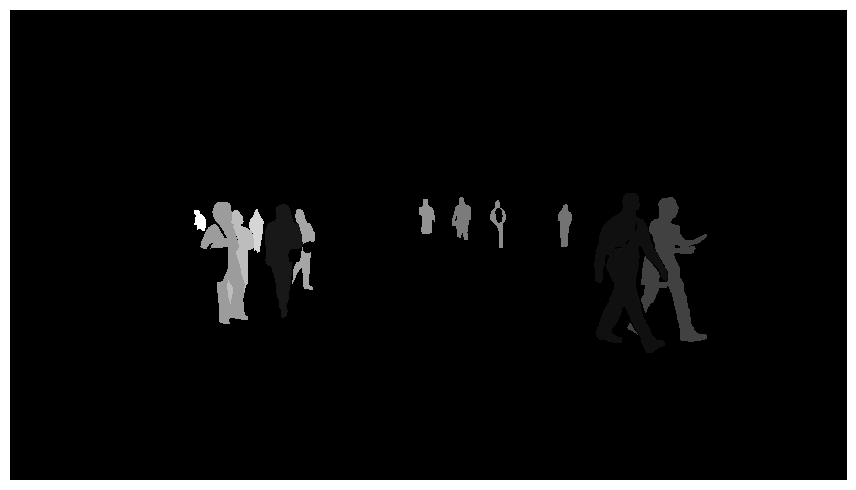

In [3]:
seq_name = 'MOT16-02'
data_dir = os.path.join(root_dir, 'data/MOT16')
sequences = MOT16Sequences(seq_name, data_dir, load_seg=True)

for seq in sequences:
    for i, frame in enumerate(seq):
        img = frame['img']
        
        dpi = 96
        fig, ax = plt.subplots(1, dpi=dpi)

        img = img.mul(255).permute(1, 2, 0).byte().numpy()
        width, height, _ = img.shape
          
        ax.imshow(img, cmap='gray')
        fig.set_size_inches(width / dpi, height / dpi)

        if 'gt' in frame:
            gt = frame['gt']
            for gt_id, box in gt.items():
                rect = plt.Rectangle(
                  (box[0], box[1]),
                  box[2] - box[0],
                  box[3] - box[1],
                  fill=False,
                  linewidth=1.0)
                ax.add_patch(rect)

        plt.axis('off')
        plt.show()

        if 'seg_img' in frame:
            seg_img = frame['seg_img']
            fig, ax = plt.subplots(1, dpi=dpi)
            fig.set_size_inches(width / dpi, height / dpi)
            ax.imshow(seg_img, cmap='gray')
            plt.axis('off')
            plt.show()
        break

# Object detector

We provide you with an object detector pretrained on the MOT challenge training set. This detector can be used and improved to generate the framewise detections necessary for the subsequent tracking and data association step.

The object detector is a [Faster R-CNN](https://arxiv.org/abs/1506.01497) with a Resnet50 feature extractor. We trained the native PyTorch implementation of Faster-RCNN. For more information check out the corresponding PyTorch [webpage](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).


## Configuration

In [4]:
obj_detect_model_file = os.path.join(root_dir, 'models/faster_rcnn_fpn.model')
obj_detect_nms_thresh = .6

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# object detector
obj_detect = FRCNN_FPN(num_classes=2, nms_thresh=obj_detect_nms_thresh)
obj_detect_state_dict = torch.load(obj_detect_model_file,
                                   map_location=lambda storage, loc: storage)
obj_detect.load_state_dict(obj_detect_state_dict)
obj_detect.eval()
obj_detect.to(device);

If you uncomment und run the following evaluation of the object detection training set, you should obtain the following evaluation result:

`AP: 0.8677356206210984 Prec: 0.9220907182151947 Rec: 0.9167998134001982 TP: 78611.0 FP: 6642.0`

In [6]:
dataset_test = MOT16ObjDetect(os.path.join(root_dir, 'data/MOT16/train'),
                              obj_detect_transforms(train=False))
def collate_fn(batch):
    return tuple(zip(*batch))
data_loader_test = DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

# evaluate_obj_detect(obj_detect, data_loader_test)

In [7]:
frame['img'].shape, torch.Tensor([[0, 1, 3, 5], [10, 20, 50, 70], [10, 20, 50, 70]]).shape

(torch.Size([3, 1080, 1920]), torch.Size([3, 4]))

In [8]:
obj_detect.detect_with_proposal(frame['img'].unsqueeze(0), torch.Tensor([[0, 1, 3, 5], [10, 20, 50, 70], [10, 20, 50, 70]]))

(tensor([[-0.3264,  0.8653,  2.7120,  5.1266],
         [ 8.9048, 15.6232, 55.8100, 73.5178],
         [ 8.9048, 15.6232, 55.8100, 73.5178]], device='cuda:0'),
 tensor([2.0256e-09, 3.0381e-12, 3.0381e-12], device='cuda:0'))

In [9]:
def bb_intersection_over_union(boxA, boxB):
	# Source: https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
 
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = (interArea + 1e-12) / float(boxAArea + boxBArea - interArea + 1e-12)
 
	# return the intersection over union value
	return iou

In [10]:
bb_intersection_over_union([1, 4, 4, 10], [1, 5, 5, 10])

0.7058823529411851

# Multi-object tracking

We provide you with a simple baseline tracker which predicts object detections for each frame and generates tracks by assigning current detections to previous detections via Intersection over Union.

Try to understand the baseline tracker and think of ideas on how to improve it with the knowledge from the lecture or even beyond.

## Configuration

In [11]:
seed = 12345
seq_name = 'MOT16-02'
data_dir = os.path.join(root_dir, 'data/MOT16')
output_dir = os.path.join(root_dir, 'output')

## Setup

In [12]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

# dataset
sequences = MOT16Sequences(seq_name, data_dir)

# tracker
# class TrackerIoUAssignment(Tracker):

#     def data_association(self, boxes, scores):
#         if self.tracks:
#             track_ids = [t.id for t in self.tracks]
#             track_boxes = np.stack([t.box for t in self.tracks], axis=0)
            
#             distance = mm.distances.iou_matrix(track_boxes, boxes, max_iou=0.5)

#             # update existing tracks
#             remove_track_ids = []
#             for t, dist in zip(self.tracks, distance):
#                 if np.isnan(dist).all():
#                     remove_track_ids.append(t.id)
#                 else:
#                     match_id = np.nanargmin(dist)
#                     t.box = boxes[match_id]
#             self.tracks = [t for t in self.tracks
#                            if t.id not in remove_track_ids]

#             # add new tracks
#             new_boxes = []
#             new_scores = []
#             for i, dist in enumerate(np.transpose(distance)):
#                 if np.isnan(dist).all():
#                     new_boxes.append(boxes[i])
#                     new_scores.append(scores[i])
#             self.add(new_boxes, new_scores)

#         else:
#             self.add(boxes, scores)
        

tracker = Tracker(obj_detect)

## Run tracker

In [13]:
time_total = 0
mot_accums = []
results_seq = {}
for seq in sequences:
    tracker.reset()
    now = time.time()

    print(f"Tracking: {seq}")

    data_loader = DataLoader(seq, batch_size=1, shuffle=False)

    for i, frame in tqdm(enumerate(data_loader), total=len(data_loader)):
#         print(i)
        tracker.step(frame)
        
        if i == -1: 
            break
 
    results = tracker.get_results()
    results_seq[str(seq)] = results

    if seq.no_gt:
        print(f"No GT evaluation data available.")
    else:
        mot_accums.append(get_mot_accum(results, seq))

    time_total += time.time() - now

    print(f"Tracks found: {len(results)}")
    print(f"Runtime for {seq}: {time.time() - now:.1f} s.")

    seq.write_results(results, os.path.join(output_dir))

print(f"Runtime for all sequences: {time_total:.1f} s.")
if mot_accums:
    evaluate_mot_accums(mot_accums,
                        [str(s) for s in sequences if not s.no_gt],
                        generate_overall=True)

Tracking: MOT16-02



Tracks found: 208
Runtime for MOT16-02: 339.5 s.
Writing predictions to: ../output/MOT16-02.txt
Runtime for all sequences: 339.5 s.


/home/deep/miniconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/motmetrics/mot.py:243: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  idx = pd.MultiIndex(levels=[[],[]], labels=[[],[]], names=['FrameId','Event'])


          IDF1   IDP   IDR  Rcll  Prcn GT MT PT ML FP   FN IDs   FM  MOTA  MOTP
MOT16-02 43.3% 64.5% 32.5% 50.1% 99.2% 62 11 35 16 76 9278 148  122 48.9% 0.086
OVERALL  43.3% 64.5% 32.5% 50.1% 99.2% 62 11 35 16 76 9278 148  122 48.9% 0.086


In [14]:

data_loader = DataLoader(sequences[0], batch_size=1, shuffle=False)

j = 0
for it in data_loader:
    break
    j += 1
    if j < 2:
        continue
    it
    break
tt = obj_detect(it['img'].to('cuda'))

In [15]:
len(tt[0]['boxes'])

16

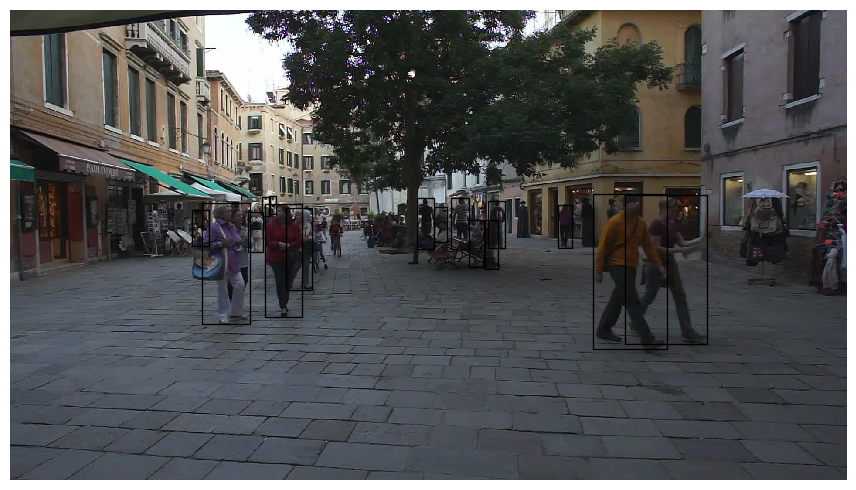

In [ ]:
img = it['img'][0]
        
dpi = 96
fig, ax = plt.subplots(1, dpi=dpi)

img = img.mul(255).permute(1, 2, 0).byte().numpy()
width, height, _ = img.shape

ax.imshow(img, cmap='gray')
fig.set_size_inches(width / dpi, height / dpi)


for gt_id, box in enumerate(tt[0]['boxes']):
    rect = plt.Rectangle(
      (box[0], box[1]),
      box[2] - box[0],
      box[3] - box[1],
      fill=False,
      linewidth=1.0)
    ax.add_patch(rect)

plt.axis('off')
plt.show()

The current state-of-the-art multi-object tracker [Tracktor++](https://arxiv.org/abs/1903.05625) achieves the following tracking results on the `MOT16-train` sequences:

              IDF1   IDP   IDR  Rcll  Prcn  GT  MT  PT  ML  FP    FN IDs   FM  MOTA  MOTP
    MOT17-02 45.8% 78.3% 32.4% 41.3% 99.8%  62   9  32  21  18 10909  59   68 40.9% 0.080
    MOT17-04 71.1% 90.3% 58.6% 64.7% 99.8%  83  32  29  22  71 16785  22   29 64.5% 0.096
    MOT17-05 64.0% 86.6% 50.7% 57.5% 98.1% 133  32  65  36  75  2942  37   59 55.8% 0.144
    MOT17-09 54.6% 69.4% 45.0% 64.3% 99.1%  26  11  13   2  31  1903  22   31 63.3% 0.086
    MOT17-10 64.3% 75.7% 55.9% 72.4% 98.0%  57  28  26   3 189  3543  71  125 70.4% 0.148
    MOT17-11 63.3% 77.0% 53.7% 69.0% 98.9%  75  24  33  18  73  2924  26   26 68.0% 0.081
    MOT17-13 73.6% 85.1% 64.8% 74.2% 97.6% 110  60  39  11 213  3000  62   90 71.9% 0.132
    OVERALL  65.0% 84.0% 53.1% 62.6% 99.1% 546 196 237 113 670 42006 299  428 61.7% 0.106

For your final submission you should focus on improving `MOTA`.

## Visualize tracking results

In [ ]:
plot_sequence(results_seq[seq_name],
              [s for s in sequences if str(s) == seq_name][0],
              first_n_frames=10)

# Notes and next steps

*   Experiment and debug on a single train sequence. If something works on a single sequence evaluate all train sequences to check the generaliztion of your improvement.
*   Remember to split the training set into multiple sets with different sequences if you train something and want to avoid overfitting.
*   Sometimes the execution of a cell gets stuck. If this happends just abort the execution and restart the cell.
*   If the notebook warns you that currently no GPU hardware acceleration is available, try again later and focus on some debugging or experiments than can be done only with the CPU.
* Try to improve your results on your local train/validation splits before submitting to our test servers. The submission will be limited to avoid overfitting to the test sequences.


# Exercise submission

The `seq.write_results(results, os.path.join(output_dir))` statement saves predicted tracks into files. After executing this notebook the `output` directory in your Google Drive should contain multiple `MOT16-XY.txt` files.

For the final submission you have to process the test sequences and upload the zipped prediction files to our server. More information on this will follow.

We will make the test sequences and minimum `MOTA` for receiving the exam bonus available by the end of december.